# HW2 - A guided surrogate attack implementation

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (27/02/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Pillow (tested on v9.3.0)
- Torch (tested on v1.13.0)
- Torchmetrics (tested on v0.11.0)

### 0. Prelim: Imports needed and testing for CUDA

In [1]:
# Future
from __future__ import print_function
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
# Torchvision
from torchvision import datasets, transforms
# Our custom ResNet and utils functions
from resnet import *
from utils import *

/Users/jyotit-kaushal/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We advise running on GPU and setting up CUDA on your machine as it might drastically speed up the running time for this notebook!

In [2]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: False


### 1. Prelim: Dataset and Dataloader

The CIFAR-10 training dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.
We will only use 1000 samples for each class (to keep the dataset small in size and reduce the execution time), hence using 10000 samples in total.

**Question 1:** Based on the description for the dataset, could you describe what seems to be the machine learning problem we will be studying? More specifically,
- Is it a supervised or unsupervised task?
- Is it a regression, classification, clustering, or association problem?
- What does the training dataset consist of, in terms of inputs and outputs?
- How many input and output features seem to be present here?
- Any additional information about the task?
Feel free to explore the dataset yourself, by using additional functions.

In [3]:
# NOTE: This is a fix to work around the "User-agent" issue 
# when downloading the CIFAR10 dataset
from six.moves import urllib
opener_req = urllib.request.build_opener()
opener_req.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener_req)

In [4]:
# Transform definition
# (Basic: only convert image to torch tensor)
tf = transforms.Compose([transforms.ToTensor()])

In [5]:
# CIFAR10 dataset and dataloader
# (Training set)
train_dataset = torchvision.datasets.CIFAR10(root = './data/', download = True, train = True, transform = tf)
train_dataset_reduced = torch.utils.data.Subset(train_dataset, [i for i in range(0, 10000)])
train_loader = torch.utils.data.DataLoader(dataset = train_dataset_reduced, batch_size = 256, shuffle = False)
print(len(train_loader))

100%|██████████| 170498071/170498071 [16:41<00:00, 170279.95it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data/
40


Similarly, the test set has 1000 images in each class, but for simplicity and reduced execution time, we will only use 20 images in each class to evaluate our attack functions (or 200 images in total).

In [5]:
# CIFAR10 dataset and dataloader
# (Testing set)
test_dataset = torchvision.datasets.CIFAR10(root = './data/', download = True, train = False, transform = tf)
test_dataset_reduced = torch.utils.data.Subset(test_dataset, [i for i in range(0, 200)])
test_loader = torch.utils.data.DataLoader(dataset = test_dataset_reduced, batch_size = 1, shuffle = False)
print(len(test_loader))

Files already downloaded and verified
200


### 2. Prelim: Our pre-trained Model under attack

We will use a simple pre-trained resnet model, with architecture and trainer stored in *resnet.py* and weights stored in file *resnet.data*.
This is a pre-trained model with a simple architecture. Its baseline accuracy is 88.16%, and a rather easy target for an attack.

**Question 2:** Based on the display for the model below, what seems to be the architecture for the model? What layers have been implemented?

In [6]:
# Load the pretrained model
original_model = ResNet(ResidualBlock, [2, 2, 2])
pretrained_model = "./resnet.data"
original_model.load_state_dict(torch.load(pretrained_model, map_location = 'cpu'))
original_model.to(device)
original_model.eval()
print(original_model)

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

### 3. Writing our attack function

**Question 3:** Write a function iufsgm_attack(), which performs an **untargeted iterated FSGM attack**.
1. It should use the Option #1, described in class, which - on each iteration of the iterated gradient attack - is aiming to move the sample away from the original class.
2. It should have a maximal number of iterations, set to 10 by default.
3. It has 5 inputs:
    - our original image,
    - the epsilon value to be used,
    - the model under attack,
    - the original label for the image,
    - and a maximal number of iterations for the attack.
4. Our attack function simply returns the attack sample to be evaluated by our test function.

In [73]:
def iufsgm_attack(image, epsilon, model, original_label, iter_num = 10):
    # Skip if epsilon is 0
    if epsilon == 0:
        return image
    elif epsilon==None:
        return image
    else:
        og_label_torch= original_label.type(torch.LongTensor)

        eps_image= image
        for i in range(iter_num):
            image.grad= None
            out= model(image)

            pred_loss= F.nll_loss(out, og_label_torch)

            pred_loss.backward(retain_graph= True)
            
            eps_image= eps_image+epsilon*torch.sign(image.grad.data)
            
            out_eps_image= model(eps_image)
            prediction= out_eps_image.max(1, keepdim=True)[1]
            
            eps_image.retain_grad()
            eps_image= torch.clamp(eps_image, 0, 1)

            if prediction!=original_label:
                # print(f"Attack succesful after iteration: {i}")
                return eps_image
        
        return eps_image

### 4. Testing your attack on your model

We will consider two different attack strategies (one-shot and iterated), with different epsilon values and numbers of maximal iterations 

#### First attack: one-shot untargeted gradient attack

If we fix max_iter = 1, we will make our iterated attack a one-shot attack.

#### Second attack: iterated untargeted gradient attack

We fix max_iter = 10.

**Question 4:** Can you suggest some epsilon values to put in the *epsilons* and *epsilons2* list below? Explain your choice of values briefly.

In [79]:
# Test First attack: one-shot untargeted gradient attack
epsilons = [0.005, 0.05]
# epsilons = [0, 2]
accuracies, examples = run_attacks_for_epsilon(epsilons, \
                                               original_model, \
                                               iufsgm_attack, \
                                               device, \
                                               test_loader, \
                                               max_iter = 1)

Epsilon: 0.005 - Model Accuracy (under attack) = 60/200 = 0.3
Epsilon: 0.05 - Model Accuracy (under attack) = 3/200 = 0.015


In [74]:
# Test Second attack: iterated untargeted gradient attack
epsilons2 = [0.005, 0.009]
accuracies2, examples2 = run_attacks_for_epsilon(epsilons2, \
                                                 original_model, \
                                                 iufsgm_attack, \
                                                 device, \
                                                 test_loader, \
                                                 max_iter = 10)

Epsilon: 0.005 - Model Accuracy (under attack) = 0/200 = 0.0
Epsilon: 0.009 - Model Accuracy (under attack) = 1/200 = 0.005


### 5. Visualization of attacks effects on pre-trained model 

As usual, we will display the accuracy vs. epsilon values graph for our given attack, as well as some samples for the given epsilon values.

The graph below will display the accuracy vs. epsilon value for both attacks.

We also suggest to show some adversarial examples, to compute the plausibility threshold value for $ \epsilon $, using the two cells below.

**Question 5:** Looking at the displays below, can you discuss which attack seems to be the most efficient on our model? Is it the one-shot or the iterated one? Is that an expected result? Discuss.

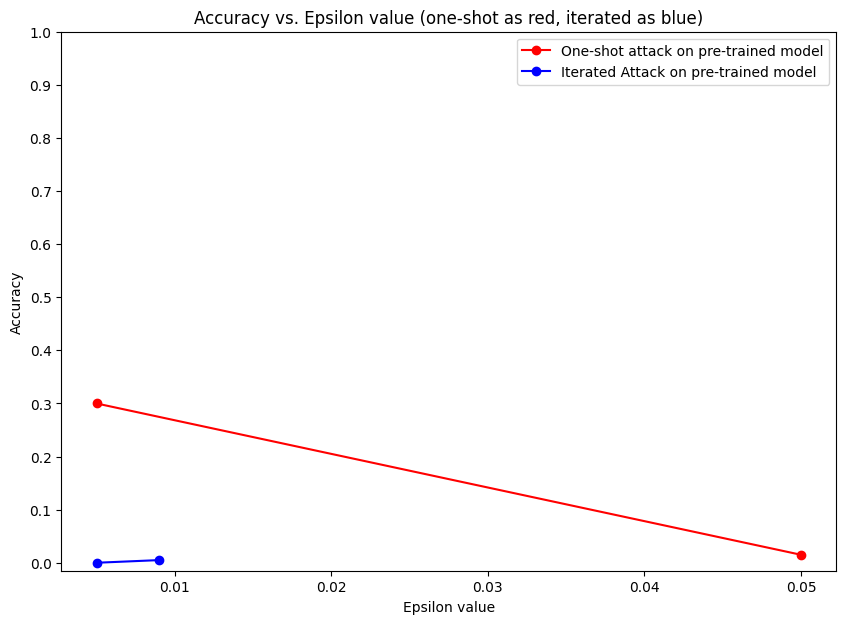

In [81]:
# Show attack curves for both attacks
display_attack_curves(epsilons, epsilons2, accuracies, accuracies2)

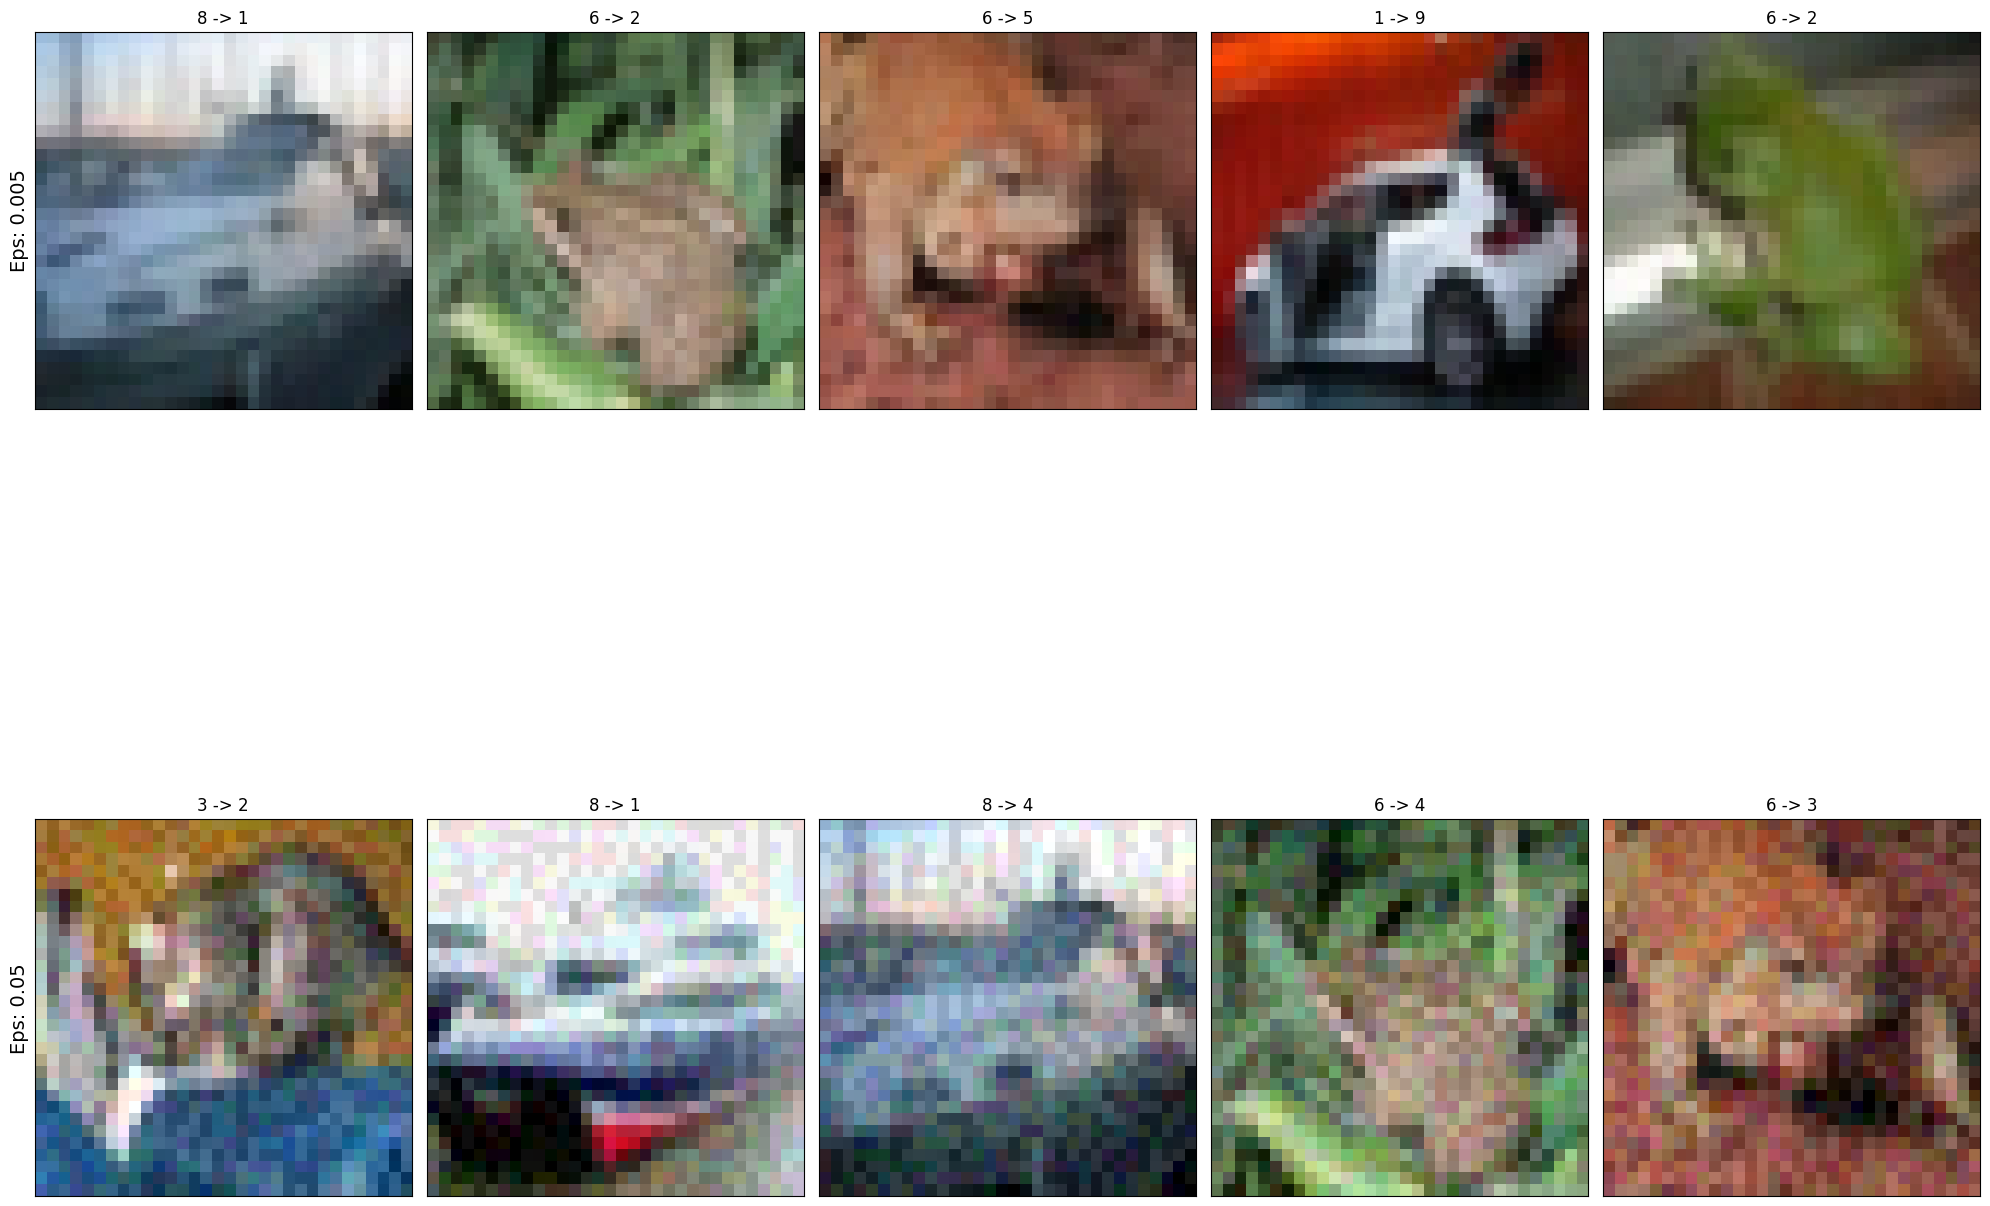

In [80]:
# Display adversarial samples for first attack
display_adv_samples(epsilons, examples)

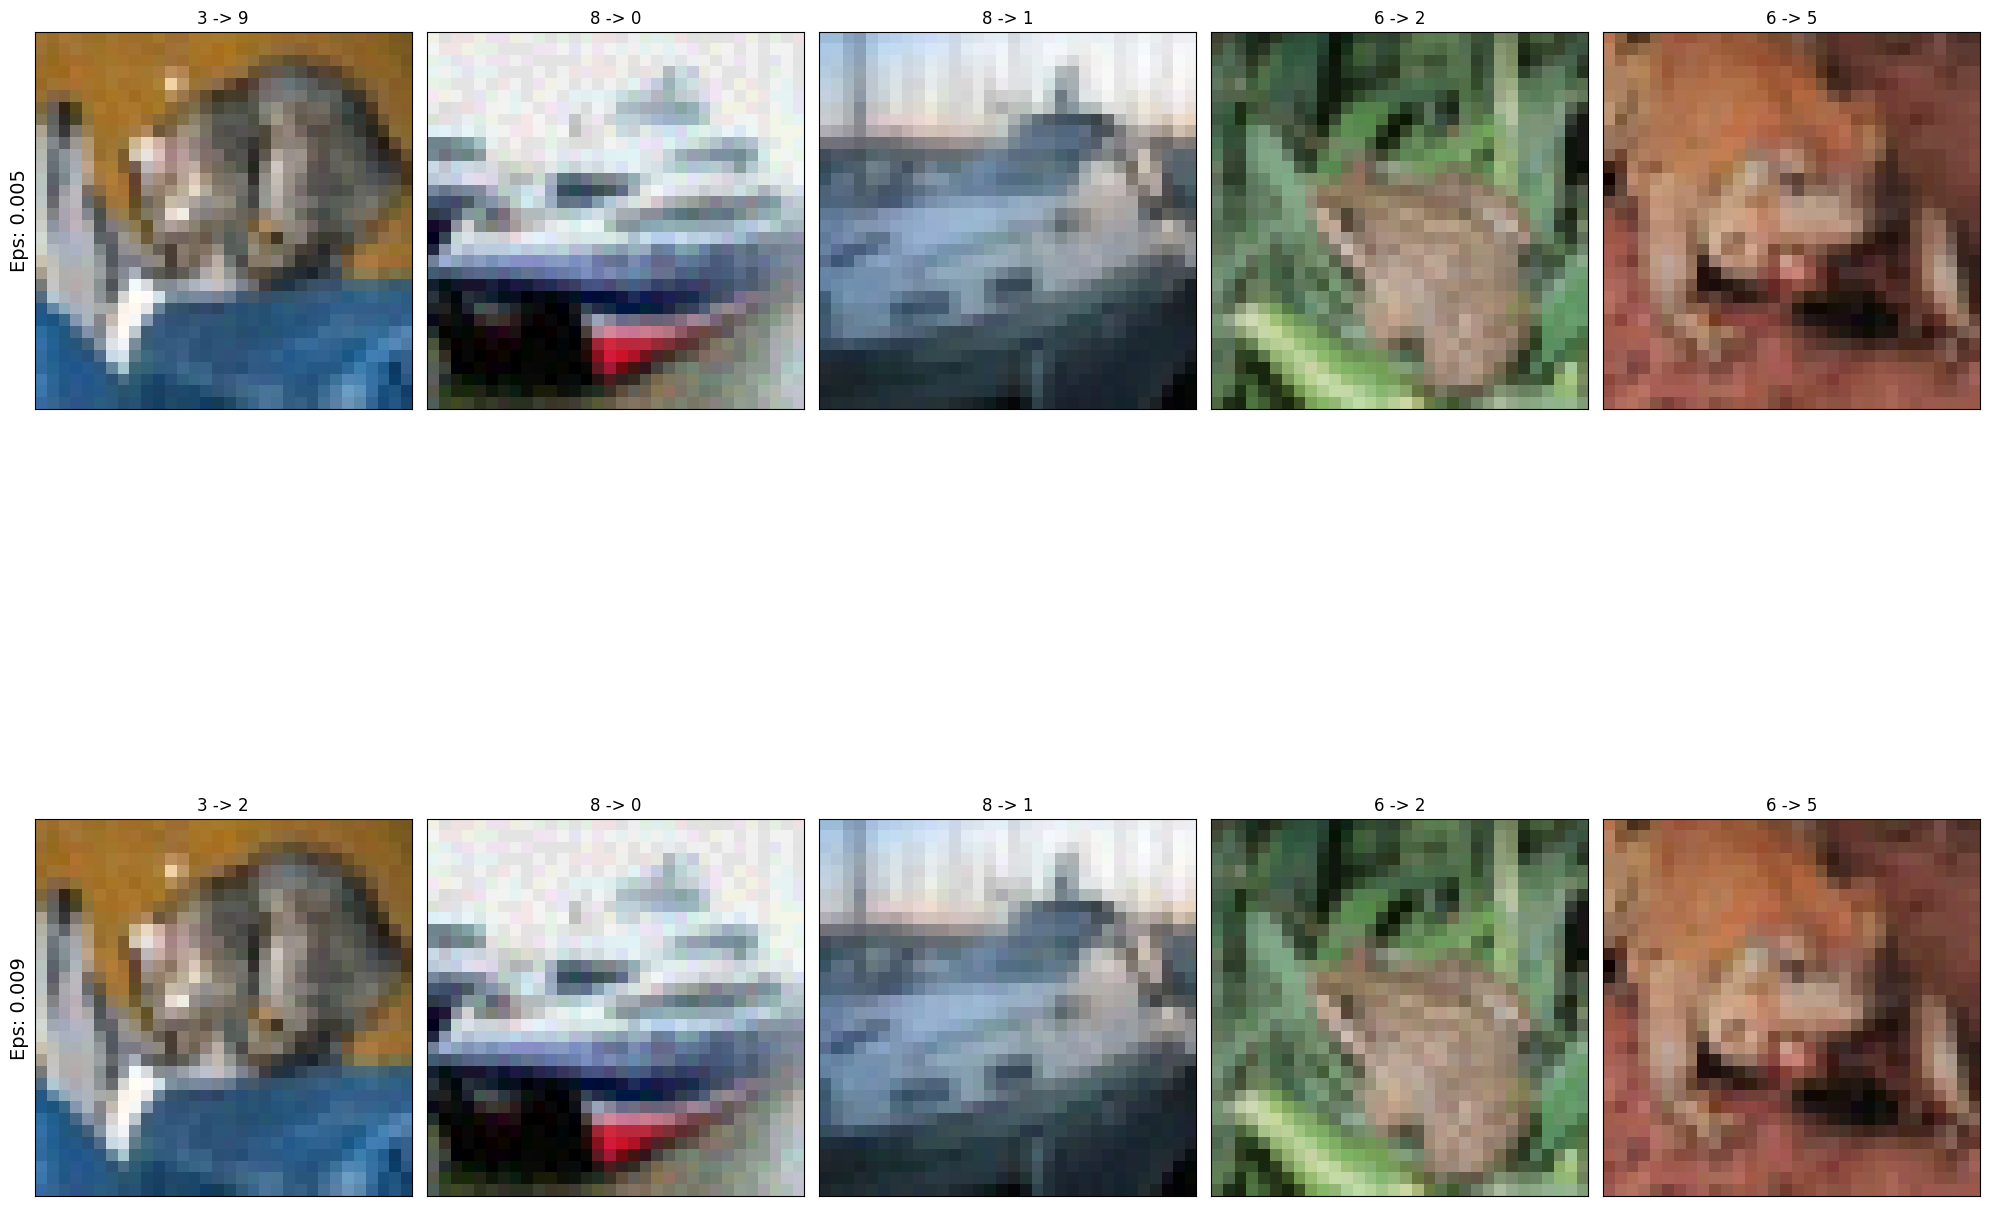

In [77]:
# Display adversarial samples for second attack
display_adv_samples(epsilons2, examples2)